## Predicting bike rentals

### Introduction

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

In this project we'll work with the data on the number of bicycles people rent by the hour in the Washington, D.C. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. You can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset). Also there you can find more info about columns of the data set.

Let's do some imports as always.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

And take a quick look at the data.

In [2]:
bike_rentals = pd.read_csv('hour.csv', parse_dates=[1])
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


We'll be predict `cnt` column - the total number of bike rentals (`casual` + `registered`).

### Data exploration

Let's explore our target a bit - male histogram.

Text(0.5, 1.0, 'Bike rental distribution')

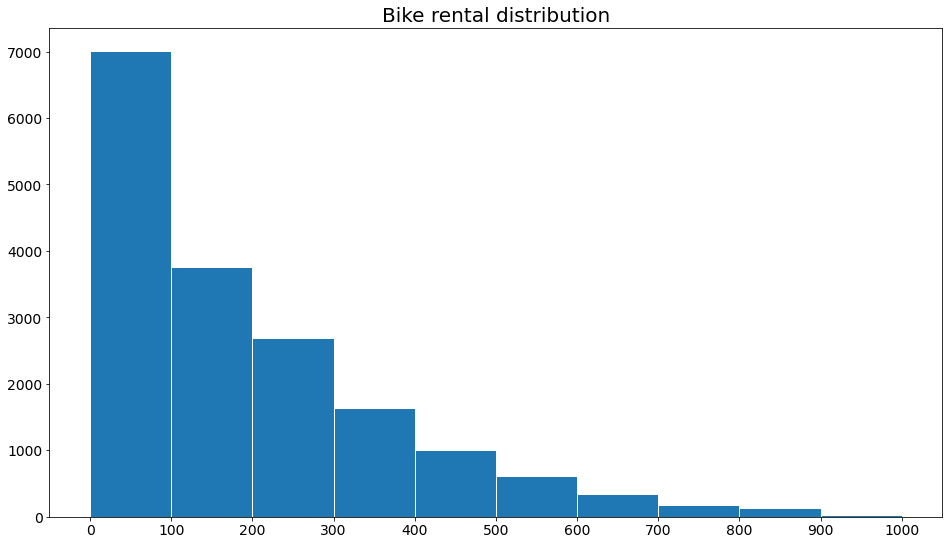

In [3]:
fig, ax = plt.subplots(figsize=(16,9))

ax.hist(bike_rentals['cnt'], bins=np.linspace(0, 1000, 11), edgecolor='white')

plt.xticks(np.linspace(0, 1000, 11), fontsize=14)
plt.yticks(fontsize=14)

ax.set_title('Bike rental distribution', fontsize=20)

It looks like the overwhelming majority lies between **0** and **100**. It means that usually there are few bike rentals per hour but sometimes it reaches over **800**.

Now let's find out what columns are correlated with the target the most. But we'll ignore some of them:
* `casual` and `registered` because they are part of the target column
* `instant` because it's just an index

In [4]:
corr_cols = bike_rentals.columns.to_list()
del corr_cols[-3:-1]
del corr_cols[0]
print(corr_cols)

['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt']


In [5]:
feature_corrs = bike_rentals[corr_cols].corr()['cnt'].abs().sort_values(ascending=False)
feature_corrs

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
hum           0.322911
yr            0.250495
season        0.178056
weathersit    0.142426
mnth          0.120638
windspeed     0.093234
holiday       0.030927
workingday    0.030284
weekday       0.026900
Name: cnt, dtype: float64

Less then half columns have significant correlation with the target. Let's take a **0.1** value as threshold so each column with higher value will be used in models.

In [6]:
usefull_features = feature_corrs[feature_corrs > 0.1].index
usefull_features

Index(['cnt', 'temp', 'atemp', 'hr', 'hum', 'yr', 'season', 'weathersit',
       'mnth'],
      dtype='object')

### Feature engineering

For now we have `hr` column that represents particular hour value. Model will threat each value differently without understanding it's meaning. But we can add some labels for **evening**, **night**, etc to clarify daytime and achieve better model accuracy.

In [7]:
def daytime(hour):
    # 1 - night
    # 2 - morning
    # 3 - afternoon
    # 4 - evening
    if hour <= 6:
        return 1
    elif hour > 6 and hour <= 12:
        return 2
    elif hour > 18:
        return 4
    else:
        return 3
    
bike_rentals['daytime'] = bike_rentals['hr'].apply(daytime)
bike_rentals['daytime'].unique()

array([1, 2, 3, 4], dtype=int64)

Let's create a list with the usefull predictors.

In [8]:
predictors = usefull_features.to_list()
predictors.remove('cnt')
predictors.append('daytime')
predictors

['temp', 'atemp', 'hr', 'hum', 'yr', 'season', 'weathersit', 'mnth', 'daytime']

### Splitting the data

We'll split our data set to the train and test parts. **80%** of the rows will go to the train set - other to the test set.

In [9]:
train_set = bike_rentals.sample(frac=0.8, random_state=1)

test_mask = bike_rentals.index.isin(train_set.index)
test_set = bike_rentals.loc[~test_mask]

We'll use **RMSE** as error metric for following models.

## Models
In this project we will apply:
* Linear regression
* Decision tree
* Random forest

### Linear regression

Firstly let's try old good linear regression to predict bike rentals. In this case we can't capture the non-linear features.

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(train_set[predictors], train_set['cnt'])
lin_predict = lin_reg.predict(test_set[predictors])
lin_rmse = mean_squared_error(test_set['cnt'], lin_predict, squared=False)
lin_rmse

139.9510454082042

Error is pretty high especially considering that a lot of rents values are lower then 100.

### Decision tree

Tree will capture non-linear features also. Let's try it.

In [11]:
dec_tree = DecisionTreeRegressor(min_samples_leaf=20)
dec_tree.fit(train_set[predictors], train_set['cnt'])
tree_predict = dec_tree.predict(test_set[predictors])
tree_rmse = mean_squared_error(test_set['cnt'], tree_predict, squared=False)
tree_rmse

90.55684064503053

That's better! But we can improve this result using random forest. It will help us handle model overfitting.

### Random forest

In [12]:
ran_for = RandomForestRegressor(min_samples_leaf=20)
ran_for.fit(train_set[predictors], train_set['cnt'])
forest_predict = ran_for.predict(test_set[predictors])
forest_rmse = mean_squared_error(test_set['cnt'], forest_predict, squared=False)
forest_rmse

87.53888550443388

Yep, RMSE is a bit smaller this time. And we've got this without any hyperparameters optimization.

## Conclusion

Choosing correct algorithm is essential skill for machine learning. It can, ceteris paribus, significantly decrease model error and improve results.

We've tried three different algorithms in this project:
* linear regression - **RMSE ~ 139.95**
* decision tree - **RMSE ~ 90.56**
* random forest - **RMSE ~ 87.54**